In [65]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlGDConfig,
    ControlEMVPConfig,
    ProposedMethodConfig,
    ProposedModifiedEMVPConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
from simple_ls_optimizer import SimpleLSOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv
from itertools import product
import seaborn as sns
from matplotlib.colors import LogNorm
import rdatasets


## Loading the dataset

In [2]:
DATASETS = set(["lynx", "ozone"])

In [3]:
DATASET = "lynx"

assert DATASET in DATASETS, f"Dataset {DATASET} not recognized. Available datasets: {DATASETS}"

In [4]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
match DATASET:
    case "lynx":
        dataset = rdatasets.data("lynx").drop(columns=["rownames"])
        dataset.set_index('time', inplace=True)
    case "ozone":
        dataset = pd.read_csv("./data/Arosa_Ozone_Thickness_Dataset.csv")
        dataset["year"] = 1925 + dataset["year"]
        dataset["time"] = pd.to_datetime(dataset[["year", "month"]].assign(day=1))
        dataset.set_index("time", inplace=True)
        dataset = dataset.rename(columns={
            "thick": "value"
        }).drop(columns=["year", "month"])
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [5]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [6]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [7]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
match DATASET:
    case "lynx":
        time_series = np.log10(time_series)
    case "ozone":
        time_series = np.log10(time_series - 260)

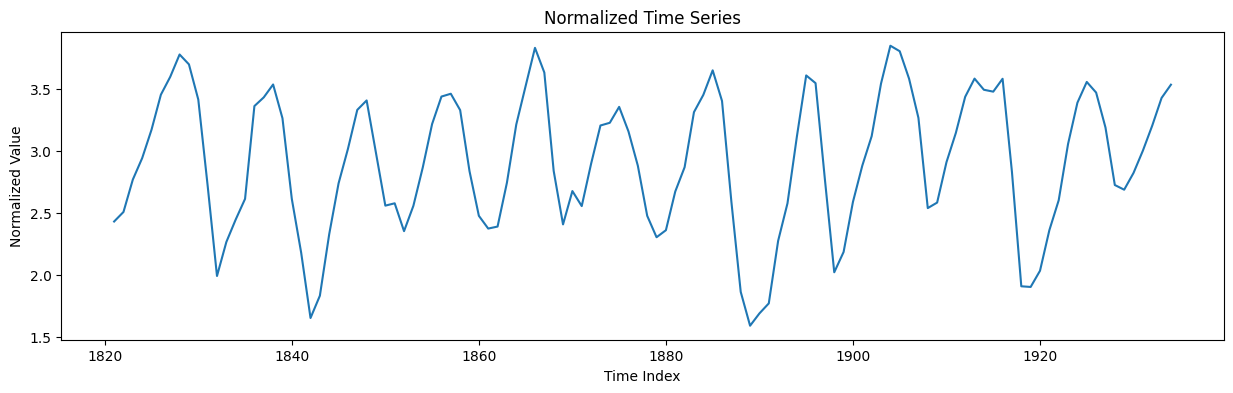

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(dataset.index, time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [9]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 2


In [10]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=False,
    ),
)
print(f"Estimated dimension: {cao_dim}")

Estimated dimension: 7


## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [11]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 2
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [12]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=2, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [13]:
tau, dim = tau_cv, dim_cv

In [72]:
proposed_configs = [
    # *[
    #     ProposedMethodConfig(
    #         approach=approach,
    #         optimizer=SvdOptimizer(epsilon=eps, alpha=alpha, beta=beta, delta=0),
    #         m=m,
    #         post_tune=post_tune,
    #         n=dim,
    #         embedding_tau=tau,
    #         # rho=rho,
    #         use_kmeans_centres=True,
    #         use_local_sigma=True,
    #         tuning_val_split=tuning_val_split,
    #         ridge=ridge # for pre-training
    #     )
    #     for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 100]
    #     # for m in [10, 15, 100, 200, 300]
    #     # for m in [100]
    #     for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
    #     # for beta in [None, 1, 10, 100]
    #     for beta in [None]
    #     # for rho in [0.1, 0.2, 0.3, 0.5, 1]
    #     # for beta in [None]
    #     for eps in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #     # for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    #     # for approach in ["pretraining", "no-pretraining"]
    #     for post_tune, tuning_val_split in filter(
    #         lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
    #         product([True, False], [0.0, 0.15])
    #     )
    #     for ridge, approach in filter(
    #         lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
    #         product(
    #             [0.0, 1e-3, 1e-2, 1e-1, 1, 5], 
    #             # ["pretraining", "no-pretraining"]
    #             ["pretraining"]
    #         )
    #     )
    # ],
    # *[
    #     ProposedMethodConfig(
    #         approach=approach,
    #         optimizer=SimpleLSOptimizer(alpha=alpha),
    #         m=m,
    #         post_tune=post_tune,
    #         n=dim,
    #         embedding_tau=tau,
    #         tuning_val_split=tuning_val_split,
    #         rho=rho,
    #         ridge=ridge # for pre-training
    #     )
    #     # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    #     for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
    #     for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 225, 300]
    #     for rho in [0.1, 0.2, 0.3, 0.5]
    #     # for approach in ["pretraining", "no-pretraining"]
    #     for post_tune, tuning_val_split in filter(
    #         lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
    #         product([True, False], [0.0, 0.15])
    #     )
    #     for ridge, approach in filter(
    #         lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
    #         product(
    #             [0.0, 1e-3, 1e-2, 1e-1], 
    #             # ["pretraining", "no-pretraining"]
    #             ["pretraining"]
    #         )
    #     )
    # ],
    # *[
    #     ProposedMethodConfig(
    #         approach=approach,
    #         optimizer=OlsOptimizer(rho=ols_rho, alpha=alpha),
    #         m=max_m,
    #         n=dim,
    #         embedding_tau=tau,
    #         post_tune=post_tune,
    #         ridge=ridge,
    #         rho=rho,
    #         tuning_val_split=tuning_val_split
    #     )
    #     for alpha in [0, 1e-2, 1, 10, 100]
    #     # for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 2, 5, 10, 20, 50]
    #     # for max_m in [50, 100, 300]
    #     for max_m in [300]
    #     for rho in [0.1, 0.2, 0.3, 0.5]
    #     for post_tune, tuning_val_split in filter(
    #         lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
    #         product([True, False], [0.0, 0.15])
    #     )        
    #     # for ols_rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
    #     for ols_rho in [0.01, 0.1, 0.3, 0.7]
    #     for ridge, approach in filter(
    #         lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
    #         product(
    #             # [0.0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5], 
    #             [1e-2, 1, 10], 
    #             ["pretraining"]
    #             # ["pretraining", "no-pretraining"]
    #         )
    #     )
    # ],
    *[
        ProposedModifiedEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [6]
        for ridge in [1e-2]
    ]
]

control_configs = [
    # *[
    #     ControlGDConfig(
    #         m=m,
    #         n=dim,
    #         embedding_tau=tau,
    #         lr=lr,
    #         sigma_global=sigma_global,
    #         ridge=ridge,
    #         val_split=0.15,
    #     )
    #     for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
    #     for lr in [1e-3, 1e-2, 5e-2, 1e-1]
    #     for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    #     for sigma_global in [False, True]
    # ],
    *[
        ControlEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [6]
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
        # for ridge in [0.0, 1e-4, 1e-3, 1e-2, 1e-1, 1]
        # for m in [10]
        for ridge in [1e-2]
    ]
]

In [73]:
TRAIN_RATIOS = {
    # "lynx": 0.88, # 0.88 for equivalence with article (no validation-test set separation though...) 
    "lynx": 0.7,
    # "ozone": 450/518
    "ozone": 0.7
}

train_ratio = TRAIN_RATIOS.get(DATASET, 0.7)

In [74]:
torch.manual_seed(0)
np.random.seed(0)

proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=train_ratio, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]



Running Experiments: 100%|██████████| 2/2 [00:00<00:00,  8.84experiment/s]


## Evaluating the results

In [75]:
VALID_RATIOS = {
    # "lynx": 0.06,
    # "lynx": 0, 
    "lynx": 0.2, 
    # "ozone": 34/518
    "ozone": 0.2
}

valid_ratio = VALID_RATIOS.get(DATASET, 0.2)

test_ratio = 1.0 - train_ratio - valid_ratio
assert test_ratio > 0, "Test ratio must be positive."

In [94]:
from tqdm import tqdm

results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
        "Valid R": [],
        "Valid R^2": [],
        "Valid MSE": [],
        "Valid RMSE": [],
        "Valid NRMSE": [],
        "Valid MAPE": [],
        "Valid SMAPE": [],
        "Valid MAAPE": [],
    }
)


use_validation_set = valid_ratio > 0

for i, res in tqdm(enumerate(proposed_results), desc="Processing proposed results", total=len(proposed_results)):
    
    cfg = proposed_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets,
    )
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata["optimizer_type"]}-w.{vars(cfg).get("approach", "N/A").replace("-", " ")}-{'tuned' if vars(cfg).get("post_tuned", False) else 'untuned'}"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in tqdm(enumerate(control_results), desc="Processing control results", total=len(control_results)):
    
    cfg = control_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"{'GD-' if isinstance(cfg, ControlGDConfig) else 'EMVP'} "],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

Processing control results: 100%|██████████| 1/1 [00:00<00:00, 303.21it/s]


In [95]:
results_df = results_df.assign(
    Optimizer=results_df['Name'].str.split('-').str[0],
    Approach=results_df['Name'].str.extract(r'-w\.([^-]+)')[0].fillna('N/A'),
    Tuned = results_df['Name'].str.contains('-tuned').fillna('N/A'),
)

In [96]:
MODEL_SELECTION_CRITERION = "Valid MSE"
MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

MODEL_EVALUATION_CRITERION = "Test MSE"
MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE = False

In [97]:
results_df.groupby(["Type", "Optimizer", "Approach", "Tuned"])[results_df.columns].apply(
    lambda x: x.sort_values(
        by=MODEL_SELECTION_CRITERION,
        ascending=not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE,
    )
    .drop(
        columns=[
            "Type",
            *[col for col in results_df.columns if col.startswith("Valid") and col != MODEL_SELECTION_CRITERION],
        ]
    )
    .head(1)
)

,,,,,Name,Test R,Test R^2,Test MSE,Test RMSE,Test NRMSE,Test MAPE,Test SMAPE,Test MAAPE,Valid MSE,Optimizer,Approach,Tuned
Type,Optimizer,Approach,Tuned,,,,,,,,,,,,,,
Control,EMVP,N/A,False,1,EMVP,0.942130,0.833423,0.014943,0.122243,0.429384,0.032701,0.01668,0.03267,0.068377,EMVP,N/A,False
Proposed,ModifiedEMVP,N/A,False,0,ModifiedEMVP-w.N/A-untuned,0.942131,0.833425,0.014943,0.122242,0.429381,0.032701,0.01668,0.03267,0.068377,ModifiedEMVP,N/A,False


In [99]:
results_of_best_model_of_each_method = {order_col:
    results_df.assign(
        Optimizer=results_df['Name'].str.split('-').str[0],
        Approach=results_df['Name'].str.extract(r'-w\.(.+)')[0].fillna('N/A'),
        Tuned = results_df['Name'].str.contains('-tuned').fillna('N/A'),
    ).groupby(["Type", "Optimizer", "Approach", "Tuned"])[results_df.columns].apply(
        lambda x: x.sort_values(
            by=order_col,
            ascending=not (order_col == "Valid R" or order_col == "Valid R^2"),
        )
        .drop(
            columns=[
                *[col for col in results_df.columns if col.startswith("Valid") and col != order_col and col != "Optimizer" and col != "Approach" and col != "Tuned"],
            ]
        )
        .head(1)
    )
    for order_col in results_df.columns if order_col.startswith("Valid")
}

In [100]:
scores_to_beat = {
    order_col: best_results[best_results["Optimizer"].str.strip() == "EMVP"][order_col.replace("Valid", "Test")].values[0]
    for order_col, best_results in results_of_best_model_of_each_method.items()
}

better_proposed_methods_according_to_metric = {
    order_col: [
        best_results[
            (best_results["Type"] == "Proposed") &
            (best_results[order_col.replace("Valid", "Test")] >= score_to_beat if order_col == "Valid R" or order_col == "Valid R^2"
            else best_results[order_col.replace("Valid", "Test")] <= score_to_beat)][["Optimizer", "Approach", "Tuned", order_col.replace("Valid", "Test")]].values
    ]
    for (order_col, best_results), (_, score_to_beat) in zip(results_of_best_model_of_each_method.items(), scores_to_beat.items())
}

winning_proposed_methods = pd.DataFrame([
    row
    for (order_col, methods), (_, score_to_beat) in zip(better_proposed_methods_according_to_metric.items(), scores_to_beat.items())
    for row in (
        [{
            'Metric': order_col,
            'Optimizer': 'None',
            'Approach': 'None',
            'Tuned': 'None',
            'Test Score': 'No proposed method outperforms EMVP'
        }] if len(methods[0]) == 0 else [
            {
                'Metric': order_col,
                'Optimizer': optimizer,
                'Approach': approach,
                'Tuned': tuned,
                'Test Score': test_score,
                'Score to Beat': score_to_beat,
                'Delta': (test_score - score_to_beat if order_col in ["Valid R", "Valid R^2"] else score_to_beat - test_score),
                    'Percentage': f"-{(test_score - score_to_beat if order_col in ["Valid R", "Valid R^2"] else score_to_beat - test_score) / abs(score_to_beat) * 100:.3f}%" if score_to_beat != 0 else "N/A"
            } for optimizer, approach, tuned, test_score in methods[0]
        ]
    )
])



In [101]:
from datetime import datetime

winning_proposed_methods.to_csv(f"./results/winning_proposed_methods_{DATASET}_{datetime.now().strftime("%Y-%m-%d,%H:%M")}.csv")

In [102]:
winning_proposed_methods.groupby(["Optimizer", "Approach", "Tuned"], sort=True)[
    winning_proposed_methods.columns
].apply(
    lambda x: x.sort_values(
        by="Test Score", ascending=x["Metric"].iloc[0] not in ["Valid R", "Valid R^2"]
    ).drop(columns=["Optimizer", "Approach", "Tuned"])
)

Metric  Test Score  Score to Beat  \
Optimizer    Approach    Tuned                                             
ModifiedEMVP N/A-untuned False 0      Valid R    0.942131       0.942130   
                               1    Valid R^2    0.833425       0.833423   
                               4  Valid NRMSE    0.429381       0.429384   
                               3   Valid RMSE    0.122242       0.122243   
                               5   Valid MAPE    0.032701       0.032701   
                               7  Valid MAAPE    0.032670       0.032670   
                               6  Valid SMAPE    0.016680       0.016680   
                               2    Valid MSE    0.014943       0.014943   

                                         Delta Percentage  
Optimizer    Approach    Tuned                             
ModifiedEMVP N/A-untuned False 0  1.178756e-06    -0.000%  
                               1  2.185269e-06    -0.000%  
                               4  2.651574e-06    -0.001%  
                               3  8.018317e-07    -0.001%  
                               5  1.843558e-07    -0.001%  
                               7  1.833947e-07    -0.001%  
                               6  9.776975e-08    -0.001%  
                               2  1.960353e-07    -0.001%

In [26]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", MODEL_SELECTION_CRITERION], ascending=[False, not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: SvdOptimizer-w.pretraining-tuned


In [64]:
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][MODEL_SELECTION_CRITERION].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][MODEL_SELECTION_CRITERION].idxmin()
best_proposed_config = proposed_configs[best_proposed_idx]
print(f"Best proposed model config:")
for key, value in vars(best_proposed_config).items():
    print(f"{key}: {value}")

Best proposed model config:
n: 2
embedding_tau: 1
sigma: None
rbf: gaussian
max_embedding_dim: 20
approach: pretraining
optimizer: <svd_based_optimizer.SvdOptimizer object at 0x00000273044B0800>
m: 7
use_kmeans_centres: True
kmeans_max_iters: 100
kmeans_tol: 0.0001
use_local_sigma: True
local_sigma_k: 5
ridge: 0.1
rho: 0.2
post_tune: False
tuning_lr: 0.003
tuning_patience: 15
tuning_max_epochs: 200
tuning_val_split: 0.15


In [27]:
AXIS_LIM = (0, 1)

Correlations between Valid and Test metrics:
Control nan
Proposed 0.9664192124469719


c:\Users\User\Documents\rbfar-ols\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\User\Documents\rbfar-ols\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\User\Documents\rbfar-ols\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\User\AppData\Local\Temp\ipykernel_84276\700292627.py:29: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)


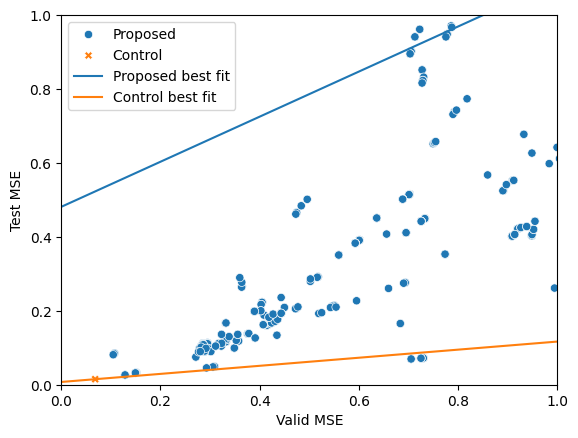

In [28]:
valid_metric = (
    MODEL_SELECTION_CRITERION
    if MODEL_SELECTION_CRITERION.startswith("Valid")
    else "Valid " + MODEL_SELECTION_CRITERION.split(" ")[1]
)
test_metric = (
    "Test " + MODEL_EVALUATION_CRITERION.split(" ")[1]
    if MODEL_EVALUATION_CRITERION.startswith("Valid")
    else MODEL_EVALUATION_CRITERION
)
sns.scatterplot(
    data=results_df, x=valid_metric, y=test_metric, hue="Type", style="Type"
)
plt.xlim(*AXIS_LIM)
plt.ylim(*AXIS_LIM)
# Calculate correlations for each category
correlations = results_df.groupby("Type")[results_df.columns].apply(
    lambda df: df[valid_metric].corr(df[test_metric])
)
print("Correlations between Valid and Test metrics:")
print("Control", correlations.get("Control", np.nan))
print("Proposed", correlations.get("Proposed", np.nan))

# Add best fit lines for each category
for typ in results_df["Type"].unique():
    subset = results_df[results_df["Type"] == typ]
    x = subset[valid_metric]
    y = subset[test_metric]
    m, b = np.polyfit(x, y, 1)
    x_line = np.linspace(*AXIS_LIM, 100)
    plt.plot(x_line, m * x_line + b, label=f"{typ} best fit")
plt.legend()
plt.show()

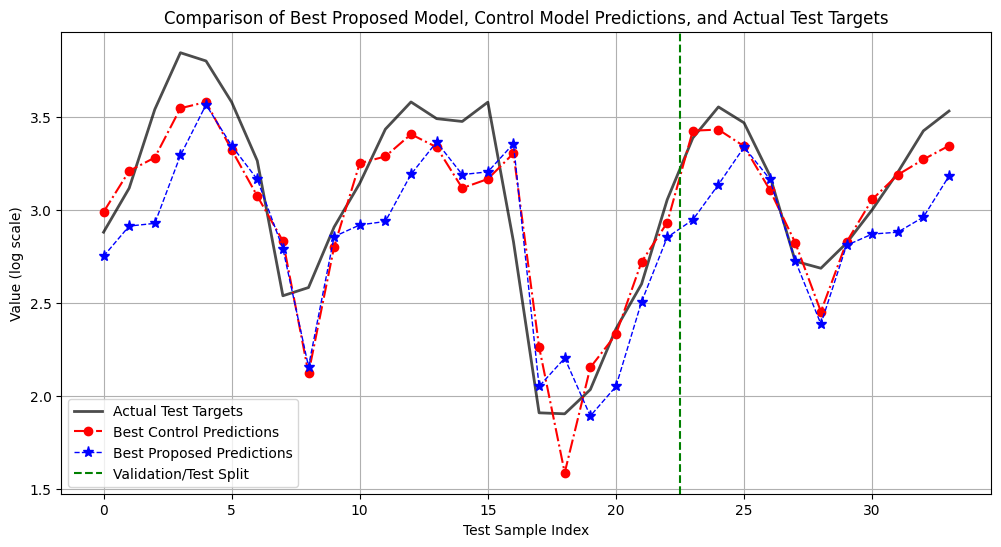

In [29]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2,  alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.axvline(x=validation_cutoff + 0.5, color='green', linestyle='--', label='Validation/Test Split')
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Effects of individual hyperparameters

In [30]:
# HYPERPARAM = "optimizer._alpha"
# HYPERPARAM = "optimizer._delta"
# HYPERPARAM = "ridge"
# HYPERPARAM = "num_components"
# HYPERPARAM = "post_tune"
HYPERPARAM = "m"
# HYPERPARAM = "approach"
# HYPERPARAM = "optimizer._beta"
# HYPERPARAM = "optimizer._epsilon"
METRIC_LOG_SCALE = True
PARAM_LOG_SCALE = True

PROPOSED_HYPERPARAM = True

OPTIMIZER_SET = set(["SimpleLSOptimizer"])

assert all(opt in list(results_df["Optimizer"].unique()) for opt in OPTIMIZER_SET), f"Some optimizers in results_df are not in the specified OPTIMIZER_SET: {OPTIMIZER_SET} (possible optimizers: {list(results_df['Optimizer'].unique())})"

AssertionError: Some optimizers in results_df are not in the specified OPTIMIZER_SET: {'SimpleLSOptimizer'} (possible optimizers: ['SvdOptimizer', 'EMVP '])

In [ ]:
DIST_PLOT_X_LIM = (0, 100000000)
# DIST_PLOT_X_LIM = (0.4, 0.45)

In [ ]:
hyperparam_values = (
    map(
        lambda cfg: cfg.__dict__.get(HYPERPARAM, None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
    if not HYPERPARAM.startswith("optimizer.")
    else map(
        lambda cfg: cfg.optimizer.__dict__.get(HYPERPARAM.split(".")[1], None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
)

hyperparam_results_df = results_df[
    results_df["Type"] == ("Proposed" if PROPOSED_HYPERPARAM else "Control")
].copy()
hyperparam_results_df[test_metric] = (
    1 - hyperparam_results_df[test_metric]
    if MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE
    else hyperparam_results_df[test_metric] - 1
)
hyperparam_results_df[HYPERPARAM] = list(hyperparam_values)

In [ ]:
hyperparam_results_df = hyperparam_results_df[
            (hyperparam_results_df[test_metric] <= DIST_PLOT_X_LIM[1]) & (hyperparam_results_df[test_metric] >= DIST_PLOT_X_LIM[0] ) 
        ]
assert not hyperparam_results_df.empty, "No results found within the specified DIST_PLOT_X_LIM."

if OPTIMIZER_SET is not None:
    hyperparam_results_df = hyperparam_results_df[
        hyperparam_results_df["Optimizer"].str.strip().isin(OPTIMIZER_SET)
    ]
    assert not hyperparam_results_df.empty, "No results found with the specified names in the given range."
    
assert hyperparam_results_df[HYPERPARAM].nunique() >= 1, "Hyperparameter has only one unique value; cannot plot."

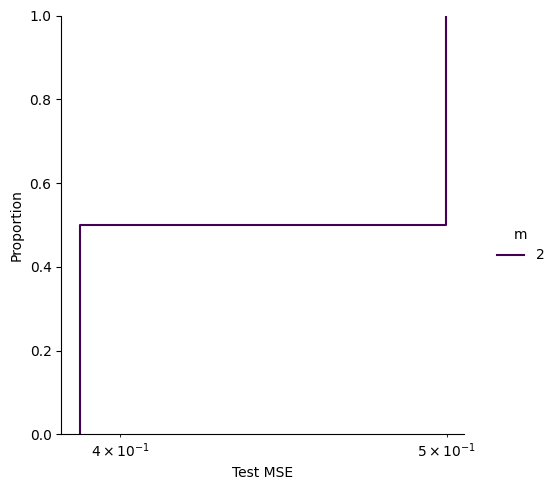

In [ ]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype

try:
    sns.displot(
        data=hyperparam_results_df,
        x=test_metric,
        hue=HYPERPARAM,
        hue_norm=(
            LogNorm()
            if PARAM_LOG_SCALE
            and is_numeric_dtype(hyperparam_results_df[HYPERPARAM])
            and not is_bool_dtype(hyperparam_results_df[HYPERPARAM])
            else None
        ),
        kind="ecdf",
        palette="viridis",
        log_scale=(METRIC_LOG_SCALE, False),
    )
except TypeError:
    sns.displot(
        data=hyperparam_results_df,
        x=test_metric,
        hue=HYPERPARAM,
        kind="ecdf",
        palette="viridis",
        log_scale=(METRIC_LOG_SCALE, False),
    )
# plt.xlim(right= np.log10(hyperparam_results_df[test_metric].max() / 10))
plt.show()

In [ ]:
# Test with just one simple configuration to debug the issue
from experiment_runner import run_proposed_experiment

print(f"Number of configurations: {len(proposed_configs)}")
print(f"First configuration: {vars(proposed_configs[0])}")

# Test with just the first configuration
single_config = proposed_configs[0]
print(f"Testing with config: approach={single_config.approach}, post_tune={single_config.post_tune}")

try:
    result = run_proposed_experiment(
        time_series, 
        single_config,
        train_ratio=train_ratio,
        device="cpu"
    )
    print("SUCCESS: Experiment completed without errors")
except Exception as e:
    print(f"ERROR: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Number of configurations: 288
First configuration: {'n': 2, 'embedding_tau': 1, 'sigma': None, 'rbf': <RadialBasisFunction.GAUSSIAN: 'gaussian'>, 'max_embedding_dim': 20, 'approach': 'pretraining', 'optimizer': <ols_optimizer.OlsOptimizer object at 0x0000018ACA748EC0>, 'm': 300, 'ridge': 0.01, 'rho': 0.1, 'post_tune': True, 'tuning_lr': 0.003, 'tuning_patience': 15, 'tuning_max_epochs': 200, 'tuning_val_split': 0.15}
Testing with config: approach=pretraining, post_tune=True
DEBUG: center_mask = tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  Tr

Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_98128\1208034296.py", line 12, in <module>
    result = run_proposed_experiment(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\Documents\rbfar-ols\experiment_runner.py", line 420, in run_proposed_experiment
    # Generate predictions using tuned weights on selected centers only
             ^^^^^^^^^^^^^^^^^
NameError: name 'P_test_for_tuning' is not defined. Did you mean: 'P_train_for_tuning'?


In [ ]:
# Let's try to reproduce the issue with a minimal test
import torch
import numpy as np

print("Testing basic tensor operations...")

# Create a simple tensor with value 78
test_tensor = torch.tensor([78])
print(f"Created tensor: {test_tensor}")

# Test if this causes the same error
try:
    mask = test_tensor < 78
    print(f"Comparison result: {mask}")
except Exception as e:
    print(f"Error in comparison: {e}")

# Test if there's something wrong with the specific value 78
try:
    centers_mock = torch.randn(78, 2)  # 78 centers, 2-dimensional
    print(f"Mock centers shape: {centers_mock.shape}")
    m = centers_mock.shape[0]
    print(f"m = {m}")
except Exception as e:
    print(f"Error with mock centers: {e}")

Testing basic tensor operations...
Created tensor: tensor([78])
Comparison result: tensor([False])
Mock centers shape: torch.Size([78, 2])
m = 78


In [ ]:
# Force reload of the experiment runner module
import importlib
import experiment_runner
importlib.reload(experiment_runner)

# Test again
from experiment_runner import run_proposed_experiment

print(f"Number of configurations: {len(proposed_configs)}")
print(f"First configuration: {vars(proposed_configs[0])}")

# Test with just the first configuration
single_config = proposed_configs[0]
print(f"Testing with config: approach={single_config.approach}, post_tune={single_config.post_tune}")

try:
    result = run_proposed_experiment(
        time_series, 
        single_config,
        train_ratio=train_ratio,
        device="cpu"
    )
    print("SUCCESS: Experiment completed without errors")
except Exception as e:
    print(f"ERROR: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Number of configurations: 288
First configuration: {'n': 2, 'embedding_tau': 1, 'sigma': None, 'rbf': <RadialBasisFunction.GAUSSIAN: 'gaussian'>, 'max_embedding_dim': 20, 'approach': 'pretraining', 'optimizer': <ols_optimizer.OlsOptimizer object at 0x0000018ACA748EC0>, 'm': 300, 'ridge': 0.01, 'rho': 0.1, 'post_tune': True, 'tuning_lr': 0.003, 'tuning_patience': 15, 'tuning_max_epochs': 200, 'tuning_val_split': 0.15}
Testing with config: approach=pretraining, post_tune=True
DEBUG: center_mask = tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  Tr

# Testing the Modified EM-VP as a Proposed Method

Let's test the new Modified EM-VP configuration to make sure everything is working correctly.

In [58]:
# Force reload the experiment runner module to pick up new changes
import importlib
import experiment_runner
importlib.reload(experiment_runner)

# Test the new Modified EM-VP configuration
from experiment_runner import ProposedModifiedEMVPConfig, run_proposed_experiment
from modified_em_vp import ModifiedEMVPConfig, ModifiedEMVPTrainer

# Create a simple test configuration
test_modified_emvp_config = ProposedModifiedEMVPConfig(
    n=dim,
    embedding_tau=tau,
    num_components=3,  # Small number for quick testing
    max_iters=50,      # Fewer iterations for quick testing
    ridge=1e-2
)

print("Testing Modified EM-VP configuration...")
print(f"Configuration: {test_modified_emvp_config}")

# Try to run a quick experiment
try:
    result = run_proposed_experiment(
        time_series, 
        test_modified_emvp_config,
        train_ratio=train_ratio,
        device="cpu"
    )
    print("SUCCESS: Modified EM-VP experiment completed!")
    print(f"Method name: {result.method_name}")
    print(f"Metadata: {result.metadata}")
    print(f"Train predictions shape: {result.train_predictions.shape}")
    print(f"Test predictions shape: {result.test_predictions.shape}")
except Exception as e:
    print(f"ERROR: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Testing Modified EM-VP configuration...
Configuration: ProposedModifiedEMVPConfig(n=2, embedding_tau=1, sigma=None, rbf=<RadialBasisFunction.GAUSSIAN: 'gaussian'>, max_embedding_dim=20, num_components=3, max_iters=50, tol_loglik=1e-05, tol_param=0.0001, min_variance=1e-06, ridge=0.01, init_responsibility_temp=1.0, init_width_scale=0.5, loglik_window=5, responsibility_floor=1e-08, device=None, dtype=torch.float32, centre_sampling_ratio=1.0, centre_restarts=1)
SUCCESS: Modified EM-VP experiment completed!
Method name: PROPOSED-ModifiedEMVP-3components
Metadata: {'tau': 1, 'n': 2, 'num_components': 3, 'final_log_likelihood': -69.60507202148438, 'optimizer_type': 'ModifiedEMVP', 'num_iterations': 24, 'approach': 'modified-emvp'}
Train predictions shape: (78,)
Test predictions shape: (34,)


## Adding Modified EM-VP to the Proposed Methods

Now that we've confirmed the Modified EM-VP works, let's add some configurations to the proposed methods list.

In [59]:
# Example: Adding Modified EM-VP configurations to your proposed methods
modified_emvp_configs = [
    ProposedModifiedEMVPConfig(
        n=dim,
        embedding_tau=tau,
        num_components=k,
        ridge=ridge_val,
        max_iters=max_iters,
    )
    for k in [3, 5, 7, 10]  # Different numbers of components
    for ridge_val in [1e-3, 1e-2, 1e-1]  # Different ridge values
    for max_iters in [100, 200]  # Different iteration limits
]

print(f"Created {len(modified_emvp_configs)} Modified EM-VP configurations")
print("Sample configuration:")
print(modified_emvp_configs[0])

# You can add these to your existing proposed_configs list:
# proposed_configs.extend(modified_emvp_configs)

Created 24 Modified EM-VP configurations
Sample configuration:
ProposedModifiedEMVPConfig(n=2, embedding_tau=1, sigma=None, rbf=<RadialBasisFunction.GAUSSIAN: 'gaussian'>, max_embedding_dim=20, num_components=3, max_iters=100, tol_loglik=1e-05, tol_param=0.0001, min_variance=1e-06, ridge=0.001, init_responsibility_temp=1.0, init_width_scale=0.5, loglik_window=5, responsibility_floor=1e-08, device=None, dtype=torch.float32, centre_sampling_ratio=1.0, centre_restarts=1)


## Example: Creating Custom Modifications

Here's how you can create your own custom modifications by overriding methods in the ModifiedEMVPTrainer class.

In [60]:
# Example: Creating a custom modification that adds noise regularization during center updates
from modified_em_vp import ModifiedEMVPTrainer, ModifiedEMVPConfig
import torch
from dataclasses import dataclass
from typing import Tuple, Optional

@dataclass
class CustomEMVPConfig(ModifiedEMVPConfig):
    """Custom config with noise regularization parameter."""
    noise_regularization: float = 0.01
    
class CustomEMVPTrainer(ModifiedEMVPTrainer):
    """Custom trainer with noise regularization during center updates."""
    
    def _update_centres_widths(self, X: torch.Tensor, responsibilities: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Custom centre and width update with added noise regularization."""
        
        # Call the base method first
        centres_new, widths_new = super()._update_centres_widths(X, responsibilities)
        
        # Add noise regularization to centers if configured
        if hasattr(self.cfg, 'noise_regularization') and self.cfg.noise_regularization > 0:
            noise = torch.randn_like(centres_new) * self.cfg.noise_regularization
            centres_new = centres_new + noise
            print(f"Applied noise regularization with scale {self.cfg.noise_regularization}")
        
        return centres_new, widths_new

# Test the custom trainer
custom_config = CustomEMVPConfig(
    num_components=3,
    max_iters=20,
    noise_regularization=0.005  # Small noise for regularization
)

print("Testing custom EM-VP trainer with noise regularization...")
try:
    from experiment_runner import make_lagged_matrix
    
    # Create simple test data
    X_test, d_test = make_lagged_matrix(time_series, dim, tau)
    split_idx = int(0.8 * len(X_test))
    X_train_test = torch.from_numpy(X_test[:split_idx]).float()
    d_train_test = torch.from_numpy(d_test[:split_idx]).float()
    
    custom_trainer = CustomEMVPTrainer(custom_config)
    custom_model = custom_trainer.fit(X_train_test, d_train_test)
    
    print("SUCCESS: Custom trainer completed!")
    print(f"Final log-likelihood: {custom_trainer.diagnostics.log_likelihood[-1]:.3f}")
    
except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()

Testing custom EM-VP trainer with noise regularization...
SUCCESS: Custom trainer completed!
Final log-likelihood: -132.168


## Summary

We have successfully created a modular and extensible EM-VP framework:

### 🔧 **Modified Base Classes (`em_vp.py`)**
- Made all helper functions into class methods in `EMVPTrainer`
- Added a `cfg` property for convenient access to configuration
- Simplified method signatures by removing the `cfg` parameter from most methods
- All methods are now overridable for customization

### 🚀 **Extended Framework (`modified_em_vp.py`)**
- `ModifiedEMVPConfig`: Extensible configuration class
- `ModifiedEMVPState`: Extended state container
- `ModifiedEMVPModel`: Extended model with custom prediction capabilities
- `ModifiedEMVPTrainer`: Extensible trainer class with overridable methods

### ⚙️ **Experiment Integration (`experiment_runner.py`)**
- `ProposedModifiedEMVPConfig`: New proposed method configuration
- `_run_proposed_with_modified_emvp()`: Dedicated experiment runner
- Full integration with the existing experimental framework
- The Modified EM-VP now runs as a **proposed method** alongside SVD/OLS approaches

### 🧪 **Usage Examples**
1. **Basic Usage**: Use `ProposedModifiedEMVPConfig` directly in your `proposed_configs`
2. **Custom Modifications**: Override methods in `ModifiedEMVPTrainer` to implement novel algorithms
3. **Parameter Sweeps**: Easy to create multiple configurations for hyperparameter tuning

### 🎯 **Next Steps**
- Add your novel modifications by overriding methods in `ModifiedEMVPTrainer`
- Add custom parameters to `ModifiedEMVPConfig` 
- Include `ProposedModifiedEMVPConfig` instances in your experiment configurations
- Compare your modifications against the baseline methods!